# Marginal rumples (Figure 4)

## Problem description

This notebook produces Figure 4 in Bezu et al. (2025). The starting point is a steady-state velocity profile associated with a near-terminus pinning point, producing a detachment zone setup with near-terminus shear stress (e.g., see Figure 3 in [Miele et al. (2023)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2022JF006959). Deflection is initially forced with a prescribed downward deflection rate at the terminus. This downward deflection then interacts with the lateral shear stresses induced by detachment zone dynamics, resulting in rumples. Notably, plastic damage is required to stabilize the rumples in this simulation. 

## Initial geometrical setup

First choose some basic initial parameters - domain size, ice temperature, timestep, etc.

In [1]:
Lx, Ly = 6000, 6000 #length, width of domain (m)
nx, ny = 200, 200 #grid resolution (m)
T = 273.15 - 0 #ice temperature (K)
κ_c = 1e-6 #critical stress threshold for plastic deflection (/m/yr)
H_gl = 300 #grounding line thickness (m)
u_gl = 50 #grounding line longitudinal velocity (m/yr)
Δt = 1/2 #timestep (years)
num_years = 100 #number of years in the simulation

μ = 0.05 #friction coefficient
term_bc = -1 #deflection boundary condition at the terminus (m/yr)

transport_solver_path = '/home/firedrake/H3F/notebooks/flow/' #where the "transport_solver" module can be imported from
figures_path = '/home/firedrake/H3F/figures/marginal_rumples/' #where figures will be saved

## Imports

In [2]:
%%capture

from firedrake import *
import icepack
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
norm = colors.TwoSlopeNorm(vcenter = 0)
import numpy as np
from operator import itemgetter
import os
import tqdm

!pip install import_ipynb #this block is to allow importing transport_solver, which is not yet a part of icepack
import import_ipynb
os.chdir(transport_solver_path) #location of the transport solver notebook
from transport_solver import TransportEquation, TransportSolver

## Material parameters

In [3]:
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater (kg/m^3)
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravitational constant (N/kg)
year = icepack.constants.year #number of seconds in a year
A = icepack.rate_factor(Constant(T)) #flow parameter

## Meshing and detachment zone setup

The detachment zone is defined by a spatially variable coefficient of sidewall friction. In this case, sidewall friction is zero over most of the domain, but it smoothly ramps up and then back down to zero within some specified distance of the terminus (see the plot below). 

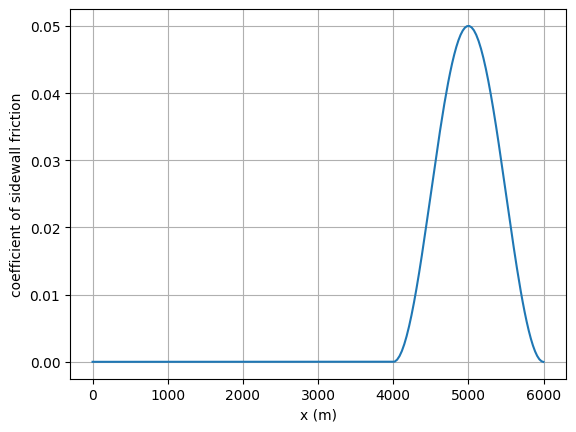

In [4]:
mesh = RectangleMesh(nx, ny, Lx, Ly, name = f'my_mesh_{nx}_{T}_{u_gl}_{μ}') #rectangle mesh
num_timesteps = int(num_years/Δt) + 1 #number of timesteps
deg = 1

Q = FunctionSpace(mesh, 'CG', deg) #function space for scalars (e.g., η)
S = TensorFunctionSpace(mesh, 'CG', deg) #function space for tensors (e.g, κ)
QS = Q*S #mixed function space for (η, κ)

q = Function(QS)
η_dot, κ_dot = split(q) #trial functions for the deflection rate and curvature rate
n_dot, k_dot = TestFunctions(QS) #test functions for those quantities
Δη = Function(Q) #function for each step's deflection update...
κ = Function(S) #...net curvature...
η = Function(Q) #...net deflection...
κ_p = Function(S) #...net plastic curvature...
γ = Function(Q) #...and unitless damage parameter

V = VectorFunctionSpace(mesh, 'CG', deg) #function space for vectors (e.g., u)
u_trial = TrialFunction(V) #trial function for the velocity
v = TestFunction(V) #test function for velocity

x, y = SpatialCoordinate(mesh)
X = np.arange(0, Lx, 1) #for plotting longitudinal profiles
X = np.array([(k, Ly/2) for k in X])

##################################
##################################
### set up the detachment zone ###
##################################
##################################

detach, δ = Lx - 1000, 1000 #detachment zone location (m), length (m)
friction = μ*(0.5*cos(pi*(x - detach)/δ) + 0.5)
friction = conditional(x > detach + δ, 0, friction)
friction = Function(Q).project(conditional(x < detach - δ, 0, friction)) #friction ramps up and then back down

Y = np.arange(0, Ly, 1) #for plotting lateral profiles
Y = np.array([(detach, k) for k in Y])

plt.figure()
plt.plot(friction.at(X, tolerance = 1e-10))
plt.ylabel('coefficient of sidewall friction')
plt.xlabel('x (m)')
plt.grid()

## Initialize SSA solver

We need to modify icepack's ```gravity``` and ```terminus``` functions to allow for surface elevations which do not perfectly align with buoyant equilibrium (since eventually vertical deflections will invalidate this). 

In [5]:
ρ_I, ρ_W = ρ_i/1e6/year**2, ρ_w/1e6/year**2 #put these values into icepack's preferred units
G = g*year**2

H_0 = Function(Q).project(Constant(H_gl)) #initial thickness
H = H_0.copy(deepcopy = True)
s = Function(Q).project((1 - ϱ)*H) #initial surface elevation

u_x = u_gl
u_y = 0
u = Function(V).project(as_vector((u_x, u_y)))

################################
################################
### modify icepack functions ###
################################
################################

def gravity(**kwargs): #see RHS of Eq. 44 in MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    return -0.5* ρ_I*G*inner(grad(H**2), u) + 0.5*ρ_W*G*inner(grad((s - H)**2), u)

def terminus(**kwargs): #see Eq. 45 from MacAyeal et al. (2021)
    u, H, s = itemgetter('velocity', 'thickness', 'surface')(kwargs)
    mesh = u.ufl_domain()
    ν = FacetNormal(mesh)
    return 0.5*ρ_I*G*H**2*inner(u, ν) - 0.5*ρ_W*G*(s - H)**2*inner(u, ν)

def effective_viscosity(**kwargs): #also define a function that returns the effective viscosity
    flow_n = 3
    u = itemgetter('velocity')(kwargs)
    ε = sym(grad(u))
    ε_min = Constant(kwargs.get('strain_rate_min', icepack.constants.strain_rate_min))
    ε_e = Function(Q).project(icepack.models.viscosity._effective_strain_rate(ε, ε_min))
    ν = 1/2*A**(-1/flow_n)*ε_e**(1/flow_n - 1) #effective viscosity in MPa*yrs
    return Function(Q).project(ν*1e6) #return ν in units of Pa*yrs

###############################
###############################
### SSA boundary conditions ###
###############################
###############################

term_ids = [2] #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
inflow_ids = [1]
sidewall_ids = [3, 4] #+/- y boundaries are sidewalls in this simulation

opts = {
    'dirichlet_ids': inflow_ids, 
    'side_wall_ids': sidewall_ids,
    'ice_front_ids': term_ids,
    'prognostic_solver_parameters': { #some optimization stuff 
        'ksp_type': 'gmres',
        'pc_type': 'ilu',
    },
}

flow_model = icepack.models.IceShelf(gravity = gravity, terminus = terminus) #model is icepack's SSA, but with our own physics
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

## Spin up to steady state

In [6]:
spinup_time = int(Lx/u_gl/4) #length of spinup in years
dt = 1 #timestep during spinup

for step in tqdm.trange(int(spinup_time/dt)):
    
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = friction,
                                     thickness = H, surface = s, fluidity = Constant(A))
    H = flow_solver.prognostic_solve(dt, thickness = H, velocity = u,
                                     thickness_inflow = H_0, accumulation = Constant(0))
    s = Function(Q).project((1 - ϱ)*H) #initial surface elevation

s_0 = Function(Q, name = f'surface_{nx}_{T}_{u_gl}').project(s)
H_0 = Function(Q, name = f'thickness_{nx}_{T}_{u_gl}').project(H)
b_0 = Function(Q).project(-ϱ*H_0) #initial basal elevation
b = b_0.copy(deepcopy = True)

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [00:36<00:00,  1.23s/it]


## Plot the initial steady-state geometry

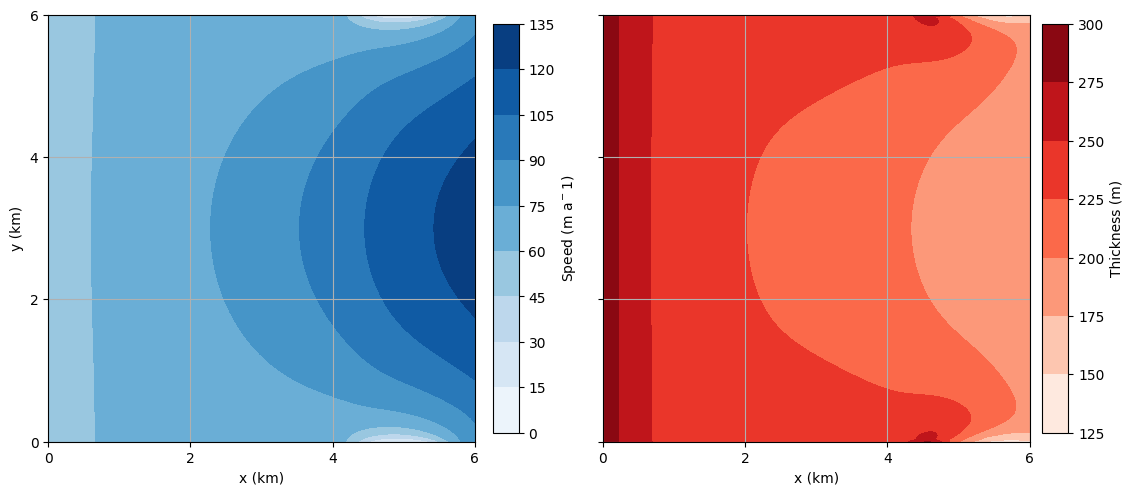

In [7]:
# Create side-by-side subplots with shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.6), sharey=True)  # Increased width to prevent overlap

# === PLOT 1: Initial Speed (Blues) ===
plot1 = tricontourf(Function(Q).project(sqrt(u[0]**2 + u[1]**2)), 
                     axes=ax1, cmap='Blues')  # Set colorbar range
ax1.set_aspect('equal')

ax1.set_xticks(range(0, Lx + 1, 2000))
ax1.set_xticklabels(range(0, int(Lx / 1000) + 1, 2))
ax1.set_yticks(range(0, Ly + 1, 2000))
ax1.set_yticklabels(range(0, int(Ly / 1000) + 1, 2))
# ax1.set_title('Initial Speed (m/yr)')
ax1.set_xlabel('x (km)')
ax1.set_ylabel('y (km)')
ax1.grid()

# === PLOT 2: Initial Thickness (Reds) ===
plot2 = tricontourf(Function(Q).project(H), axes=ax2, cmap='Reds')  # Set colorbar range
ax2.set_aspect('equal')

ax2.set_xticks(range(0, Lx + 1, 2000))
ax2.set_xticklabels(range(0, int(Lx / 1000) + 1, 2))
# ax2.set_title('Initial Thickness (m)')
ax2.set_xlabel('x (km)')
ax2.grid()

# === COLORBARS ===
# Adjusted to match **exact height** of the plots
pos1 = ax1.get_position()
pos2 = ax2.get_position()

cax1 = fig.add_axes([pos1.x1 + 0.00, pos1.y0 + 0.02, 0.02, pos1.height - 0.04])  # Now exactly as tall as plot 1
cax2 = fig.add_axes([pos2.x1 + 0.00, pos2.y0 + 0.02, 0.02, pos2.height - 0.04])  # Now exactly as tall as plot 2

cbar1 = fig.colorbar(plot1, cax=cax1)
cbar2 = fig.colorbar(plot2, cax=cax2)

cbar1.ax.set_ylabel(f'Speed (m a$^{-1}$)')
cbar2.ax.set_ylabel('Thickness (m)')

# Adjust layout with **precise horizontal spacing**
plt.subplots_adjust(wspace=0.3, right=0.88)  # Slightly increased `wspace` for balance

plt.show()

## Initialize transport solver and flexure boundary conditions

Along the terminus, we prescribe a parabolic-shaped boundary condition, permitting a downward deflection rate at the centerline (of velocity ```term_bc```), but which smoothly approaches a no-slip condition at either sidewall. This is to maintain consistency with a second boundary condition, which enforces the same zero-slip boundary condition at the sidewalls. At the inflow boundary, $\dot{\eta} = \dot{\boldsymbol{\kappa}} = 0$. 

In [8]:
########################
########################
### transport solver ###
########################
########################

transport_model = TransportEquation(field_name = 'field', conservative = False) #for advection of necessary variables
transport_solver = TransportSolver(transport_model, **opts) #e.g., η

###################################
###################################
### flexure boundary conditions ###
###################################
###################################

η_curve = Function(Q).project(term_bc*(1 - 4*(y - Ly/2)**2/Ly**2)) 
κ_gl = DirichletBC(QS.sub(1), 0*Identity(2), inflow_ids)
η_gl = DirichletBC(QS.sub(0), 0, inflow_ids)
η_sides = DirichletBC(QS.sub(0), 0, sidewall_ids)
η_term = DirichletBC(QS.sub(0), η_curve, term_ids)

########################
########################
### set figures path ###
########################
########################

path = figures_path + f'viscoplastic/H-{H_gl}_u-{u_gl}_T-{T}_nx-{nx}_μ-{μ}_κ-{κ_c}_Δt-{Δt}_term-{term_bc}'

try:
    os.chdir(path)
except:
    os.mkdir(path)
    os.chdir(path)

In [9]:
os.getcwd()

'/home/firedrake/H3F/figures/marginal_rumples/viscoplastic/H-300_u-50_T-273.15_nx-200_μ-0.05_κ-1e-06_Δt-0.5_term--1'

## Solve flow-flexure problem with firedrake

...following the steps laid out in Appendix B. 

100%|██████████████████████████████████████████████████████████████████████████████▌| 200/201 [1:09:11<00:24, 24.96s/it]

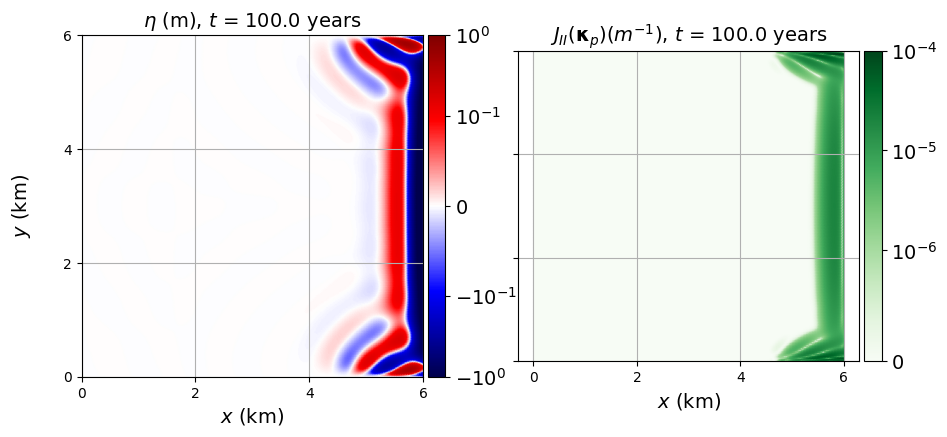

100%|███████████████████████████████████████████████████████████████████████████████| 201/201 [1:09:32<00:00, 20.76s/it]


In [10]:
η_profile, κ_profile  = [], [] #for plotting development over time

for step in tqdm.trange(num_timesteps):
    
    #########################
    #########################
    ### (1) flow solution ###
    #########################
    #########################
        
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = friction, 
                             thickness = H, surface = s)
    b = flow_solver.prognostic_solve(Δt, thickness = b, velocity = u,
                                     thickness_inflow = b_0, accumulation = Constant(0))
    s = flow_solver.prognostic_solve(Δt, thickness = s, velocity = u,
                                     thickness_inflow = s_0, accumulation = Constant(0))     

    ##########################################
    ##########################################
    ### (2) update flow-related parameters ###
    ##########################################
    ##########################################
    
    s = Function(Q).project(s)
    H = Function(Q).project(s - b) #initial basal elevation
        
    ε = Function(S).project(sym(grad(u))) #strain rate tensor from flow
    ν = effective_viscosity(velocity = u) #effective viscosity
    τ = Function(S).project(2*ν*ε) #deviatoric stress tensor from flow
    P = -tr(τ) + 1/2*ρ_i*g*H #depth-averaged pressure
    σ = τ - P*Identity(2) #depth-averaged net stress tensor from flow

    h_ab = Function(Q).project(s - (1 - ϱ)*H) #difference between s and its equilibrium value
    
    ############################
    ############################
    ### (3) flexure solution ###
    ############################
    ############################

    q = Function(QS)
    η_dot, κ_dot = split(q)
    
    J_II = sqrt(1/2*(κ_dot[0, 0]**2 + κ_dot[1, 1]**2 + κ_dot[0, 1]**2 + κ_dot[1, 0]**2)) #J_II of κ_dot
    β = 1/2 #as described in Appendix B
    α = conditional(J_II > κ_c, (κ_c + β*(J_II - κ_c))/J_II, 1) #Appendix B

    C = Function(Q).project(1/6*ν*H**3)
    a = dot(div(C*κ_dot + C*tr(κ_dot)*Identity(2)), grad(n_dot))*dx - n_dot*ρ_w*g*η_dot*Δt*dx - dot(grad(η_dot*Δt), div(n_dot*H*σ))*dx   
    a += α*inner(ν*κ_dot, k_dot)*dx + dot(grad(η_dot), div(ν*k_dot))*dx
    L = n_dot*ρ_w*g*(h_ab)*dx + dot(grad(η), div(n_dot*H*σ))*dx #the weak form given in Appendix B 

    solve(a - L == 0, q, bcs = [η_gl, κ_gl, η_term, η_sides])

    ########################################################
    ########################################################
    ### (4) update and advect flexure-related parameters ###
    ########################################################
    ########################################################

    Δη.project(η_dot*Δt) #update the change in deflection...
    η.project(η + Δη) #...the resulting net deflection...
    Δκ = κ_dot*Δt #...the change in curvature...
    κ.project(κ + Δκ) #...the resulting net curvature...
    κ_p.project(κ_p + (α - 1)*Δκ) #...and the resulting net plastic curvature
    
    s.project(s + Δη) #update the surface elevation
    b.project(b + Δη) #and the basal elevation
    Δs = Function(Q).project(s - s_0) #and also record the change in surface elevation for a more intuitive parameter to plot

    #also define each component of the curvature tensors explicitly for advection
    κ_xx, κ_xy, κ_yy = Function(Q).project(κ[0, 0]), Function(Q).project(1/2*(κ[0, 1] + κ[1, 0])), Function(Q).project(κ[1, 1])
    κp_xx, κp_xy, κp_yy = Function(Q).project(κ_p[0, 0]), Function(Q).project(1/2*(κ_p[0, 1] + κ_p[1, 0])), Function(Q).project(κ_p[1, 1])

    η = transport_solver.prognostic_solve(Δt, field = η, velocity = u, field_inflow = η, field_accumulation = Constant(0)) #advect
    η = Function(Q).project(η)

    κ_xx = transport_solver.prognostic_solve(Δt, field = κ_xx, velocity = u, field_inflow = κ_xx, field_accumulation = Constant(0))
    κ_xy = transport_solver.prognostic_solve(Δt, field = κ_xy, velocity = u, field_inflow = κ_xy, field_accumulation = Constant(0))
    κ_yy = transport_solver.prognostic_solve(Δt, field = κ_yy, velocity = u, field_inflow = κ_yy, field_accumulation = Constant(0))
    κp_xx = transport_solver.prognostic_solve(Δt, field = κp_xx, velocity = u, field_inflow = κp_xx, field_accumulation = Constant(0))
    κp_xy = transport_solver.prognostic_solve(Δt, field = κp_xy, velocity = u, field_inflow = κp_xy, field_accumulation = Constant(0))
    κp_yy = transport_solver.prognostic_solve(Δt, field = κp_yy, velocity = u, field_inflow = κp_yy, field_accumulation = Constant(0))
    
    κ.project(as_tensor([[κ_xx, κ_xy], [κ_xy, κ_yy]]))
    κ_p.project(as_tensor([[κp_xx, κp_xy], [κp_xy, κp_yy]]))
    γ.project(sqrt(1/2*(κ_p[0, 0]**2 + κ_p[1, 1]**2 + κ_p[0, 1]**2 + κ_p[1, 0]**2))) #damage as J_II(κ_p)

    η_profile.append(η.at(Y, tolerance = 1e-10))
    κ_profile.append(γ.at(Y, tolerance = 1e-10))

    ########################
    ########################
    ### (5) plot results ###
    ########################
    ########################

    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'wspace': 0.2})

    plots = [(η, 'seismic', colors.SymLogNorm(linthresh=0.1, base=10, vmin=-1, vmax=1), r'$\eta$ (m)'),
             (γ, 'Greens', colors.SymLogNorm(linthresh=1e-6, base=10, vmin=0, vmax=1e-4), r'$J_{II}(\mathbf{\kappa}_p) (m^{-1})$')]
    for ax, (data, cmap, norm, title) in zip(axes, plots):
        ax.set_aspect('equal')
        plot = tripcolor(data, axes=ax, cmap=cmap, norm=norm)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(plot, cax=cax)
        cbar.ax.tick_params(labelsize=14, direction='out')
        ax.set_xticks(range(0, Lx + 1, 2000))
        ax.set_xticklabels(range(0, int(Lx / 1000) + 1, 2), fontsize=10)
        ax.set_xlabel('$x$ (km)', fontsize=14)
        ax.set_title(f'{title}, $t$ = {step * Δt:.1f} years', fontsize=14)
        ax.grid()
    axes[0].set_yticks([])  # Remove y-ticks from the left plot
    axes[1].set_yticks(range(0, Ly + 1, 2000))
    axes[1].set_yticklabels(range(0, int(Ly / 1000) + 1, 2), fontsize=10)
    axes[1].yaxis.tick_left()
    axes[1].yaxis.set_label_position("left")
    axes[0].set_xlim(0, Lx)
    axes[1].set_ylim(0, Ly)
    fig.text(0.04, 0.5, '$y$ (km)', va='center', ha='center', fontsize=14, rotation=90)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2)
    plt.savefig(f'η_κ_{step}.png')
    
    if num_timesteps - step > 1:
        plt.close()
    else:
        plt.show() #only show the last plot

## Save figures for manuscript

In [11]:
# Font size settings
fontsize, fontsize_ticks = 12, 10

# Create figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(9.8, 5.6), sharey=True, constrained_layout=False)
κ_y_min, κ_y_max = 0, Ly

# Assign axes
ax1, ax2 = axes

# Plot data
ax1.set_aspect('equal')
im1 = tripcolor(η, axes=ax1, cmap='seismic',
                norm=colors.SymLogNorm(linthresh=0.1, base=10, vmin=-1, vmax=1))

ax2.set_aspect('equal')
im2 = tripcolor(γ, axes=ax2, cmap='Greens',
                norm=colors.SymLogNorm(linthresh=1e-6, base=10, vmin=0, vmax=1e-4))

# Set x-axis limits and ticks (restrict to 4-6 km)
for ax in [ax1, ax2]:
    ax.set_xlim(Lx - 2000, Lx)
    ax.set_xticks(range(Lx - 2000, Lx + 1, 1000))
    ax.set_xticklabels(range((Lx - 2000) // 1000, Lx // 1000 + 1), fontsize=fontsize_ticks)
    ax.grid()

# Set y-axis ticks and labels
ax1.set_ylim(κ_y_min, κ_y_max)
ax2.set_ylim(κ_y_min, κ_y_max)
ax1.set_yticks(range(0, Ly + 1, 2000))
ax1.set_yticklabels(range(0, Ly // 1000 + 1, 2), fontsize=fontsize_ticks)
ax1.set_ylabel('y (km)', fontsize=fontsize)

# Set x-axis labels
ax1.set_xlabel('x (km)', fontsize=fontsize)
ax2.set_xlabel('x (km)', fontsize=fontsize)

# Adjust subplot positions for reduced horizontal spacing
ax1.set_position([0.1, 0.1, 0.4, 0.85])
ax2.set_position([0.3, 0.1, 0.4, 0.85])

# Move colorbars closer, stacked vertically
cax1 = fig.add_axes([0.65, 0.60, 0.03, 0.35])
cax2 = fig.add_axes([0.65, 0.1, 0.03, 0.35])

# Add and format colorbars
fig.colorbar(im1, cax=cax1).ax.tick_params(labelsize=fontsize_ticks, pad=4)
fig.colorbar(im2, cax=cax2).ax.tick_params(labelsize=fontsize_ticks, pad=4)

# Add dashed black lines
ax1.plot([5e3, 5e3], [0, 3e3], 'k--', linewidth=1, dashes=(5, 5))
ax2.plot([5e3, 5e3], [0, 1e3], 'k--', linewidth=1, dashes=(5, 5))

# Save and show figure
plt.savefig('figure_3_CD', dpi=300)
plt.close()

In [12]:
# Font sizes
fontsize, fontsize_ticks = 12, 10
density = 1

# Expand profiles efficiently
κ_profile_expanded = np.repeat(κ_profile, density, axis=0).T
η_profile_expanded = np.repeat(η_profile, density, axis=0).T

# Define axis ranges
η_y_min, η_y_max, κ_y_min, κ_y_max = 0, 3000, 0, 1000
time_max = 100  # X-axis range
time_ticks = np.linspace(0, time_max, 5)

# Create figure and subplots with fixed height
fig = plt.figure(figsize=(5.6, 5.6))
ax1 = fig.add_axes([0.1, 0.35, 0.8, 0.6])  # Top subplot
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2])  # Bottom subplot

# First subplot (η profile)
im1 = ax1.imshow(η_profile_expanded, cmap='seismic',
                 norm=colors.SymLogNorm(linthresh=0.1, base=10, vmin=-1, vmax=1),
                 aspect='auto', extent=[0, time_max, 0, Lx])

# Second subplot (κ profile)
im2 = ax2.imshow(κ_profile_expanded, cmap='Greens',
                 norm=colors.SymLogNorm(linthresh=1e-6, base=10, vmin=0, vmax=1e-4),
                 aspect='auto', extent=[0, time_max, 0, Lx])

# Set y-axis labels and ticks
ax1.set_ylim(η_y_min, η_y_max)
ax1.set_yticks([0, 1000, 2000, 3000])  # 4 ticks
ax1.set_yticklabels(['0', '1', '2', '3'], fontsize=fontsize_ticks)
ax1.set_ylabel('y (km)', fontsize=fontsize)
ax1.grid()

ax2.set_ylim(κ_y_min, κ_y_max)
ax2.set_yticks([0, 1000])  # 2 ticks
ax2.set_yticklabels(['0', '1'], fontsize=fontsize_ticks)
ax2.set_ylabel('y (km)', fontsize=fontsize)
ax2.grid()

# Ensure shared x-axis
ax1.set_xticklabels([])
ax2.set_xticks(time_ticks)
ax2.set_xticklabels([f'{int(t)}' for t in time_ticks], fontsize=fontsize_ticks)
ax2.set_xlabel('time (years)', fontsize=fontsize)

# Save and show figure
plt.savefig('figure_3_AB.png', dpi=300)
plt.close()